In [2]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

from IPython.display import SVG

TensorFlow 梯度函数
=========

版本信息：remotes/upstream/r1.8
```
~/W/g/t/t/cc ❯❯❯ git log -n 1                                                      
commit 8753e2ebde6c58b56675cc19ab7ff83072824a62 (HEAD, upstream/r1.8)
Author: Yifei Feng <1192265+yifeif@users.noreply.github.com>
Date:   Fri Apr 27 17:05:02 2018 -0700

    Fixing the mock import error for devel docker. (#18940)

    * Fixing the mock import error for devel docker.

    Same as #18843
```

### 0 常见位置


梯度函数在Python侧和C++侧，均有独立的注册机制。

对于Python侧的梯度函数实现，一般在 `tensorflow/python/ops` 目录下，以 `_grad` 后缀结尾，如 `array_grad.py`。

对于C++侧的梯度函数实在，

+ kernel:
+ op: cc/gradient: 泛的接口
+ core/ops: 静态接口



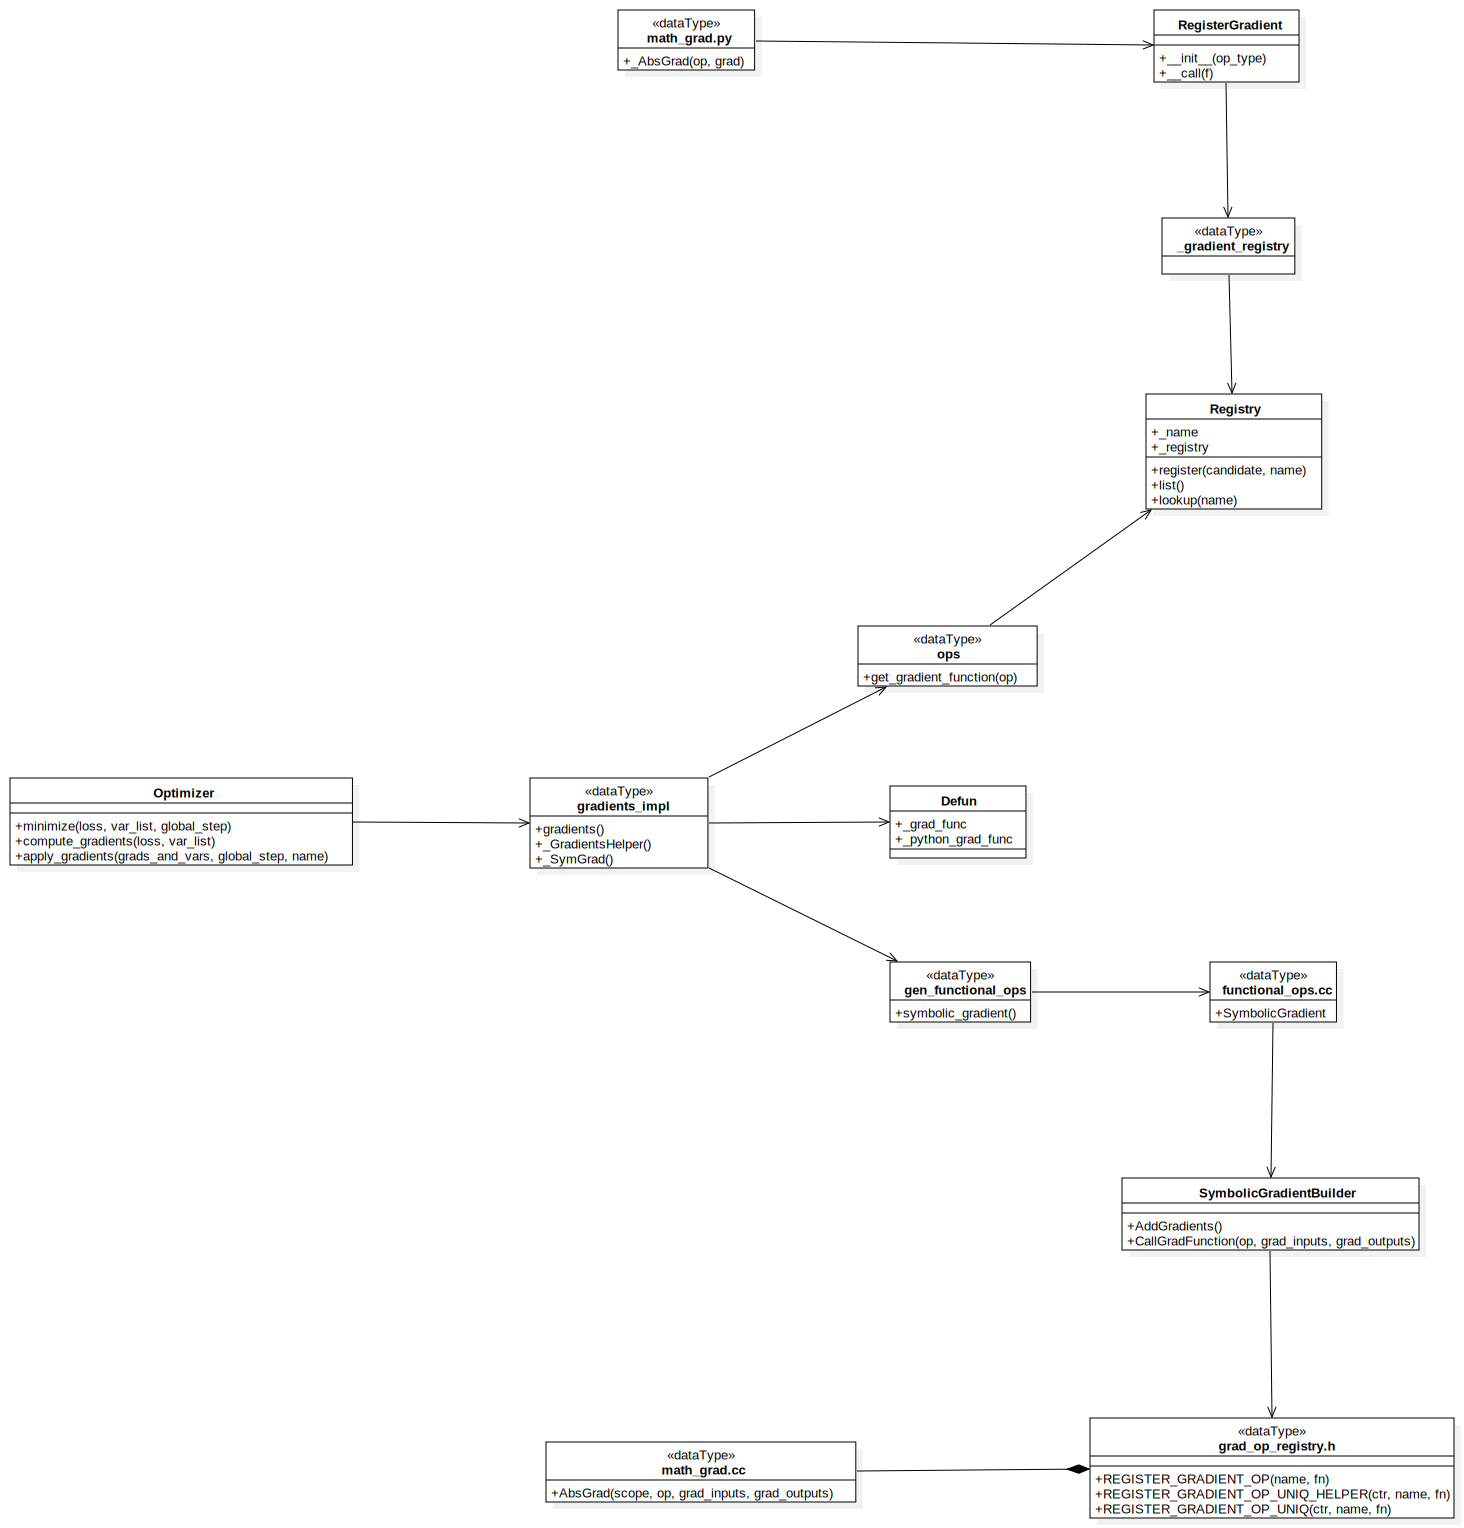

In [3]:
SVG('./res/tf_gradients.svg')

### 1 如何写Gradient函数

+ python侧
+ c++侧

拿Square作例子，细讲Grad和GradGrad的具体推导


```bash
kernels/cwise_ops.h: 含有Eigen扩展：functor和numext
kernels/cwise_ops_gradients.h: 导数
```


### Gradient

```cpp
Status SquareGrad(const Scope& scope, const Operation& op,
                  const std::vector<Output>& grad_inputs,
                  std::vector<Output>* grad_outputs) {
  // dy/dx = (2 * x)
  auto two = Cast(scope, Const(scope, 2), op.input(0).type());
  auto dydx = Mul(scope, two, op.input(0));
  // grad(x) = grad(y) * conj(dy/dx)
  grad_outputs->push_back(
      Mul(scope, grad_inputs[0], ConjugateHelper(scope, dydx)));
  return scope.status();
}
REGISTER_GRADIENT_OP("Square", SquareGrad);
```

+ `op.input`和`op.output`是`Square`输入x和输出y = x^2。
+ `grad_inputs[0]`是反向传导的后级导数`dy`，其实是`dL/dy`的简写。
+ 这个函数要计算`dx`，是`dy/dx`的简写, 结果是2 x。
+ 返回结果写入`grad_outputs`里，`dL/dx = dL/dy * dy/dx`。

如果输入有多个`x = (x0, x1, ..., xn)`，要分别算对应的导数`[dL/dx0, dL/dx1, ... dL/dxn]`。


注意：对于XXXGradGrad后缀的导数算子，将它当作XXXGrad的一阶导处理，并非是从损失过来的二阶导数。不要以为这是二阶导的反向传导。

具体见手写笔记。




### 2 梯度注册与查找


反向推导使用的是gradient function，先用python注册，没有再去c++那查。
只在TestCase中用数值方法来检查实现。

https://stackoverflow.com/questions/36370129/does-tensorflow-use-automatic-or-symbolic-gradients